# Processing and narrating a video with GPT-4o's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4o doesn't take videos as input directly, but we can use vision and the 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4o to get a description of a video
2. Generating a voiceover for a video with GPT-o and the TTS API


In [1]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))

## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [2]:
video = cv2.VideoCapture("data/bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

618 frames read.


Display frames to make sure we've read them in correctly:


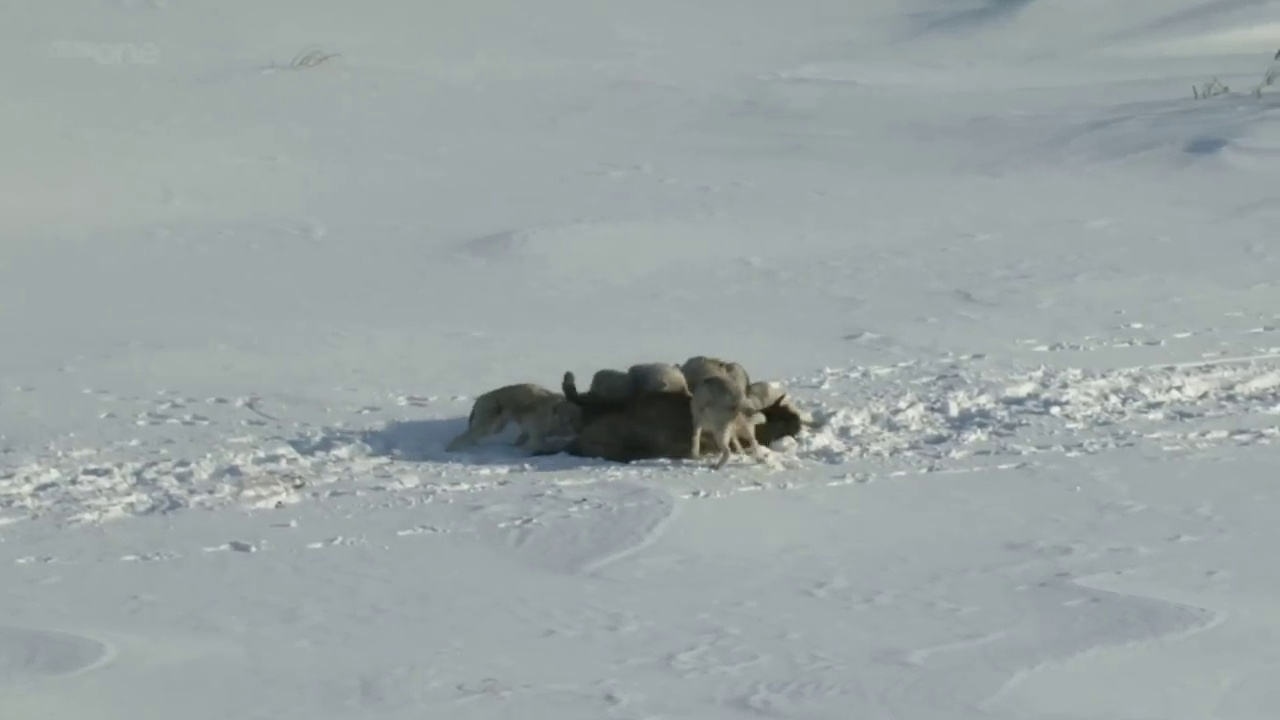

In [3]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [4]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

Title: "Epic Wildlife Showdown: Wolves vs. Bison in the Snow"

Description: 
Witness the raw power and strategy of nature in this intense and breathtaking video! A pack of wolves face off against a herd of bison in a dramatic battle for survival set against a stunning snowy backdrop. See how the wolves employ their cunning tactics while the bison demonstrate their strength and solidarity. This rare and unforgettable footage captures the essence of the wild like never before. Who will prevail in this ultimate test of endurance and skill? Watch to find out and experience the thrill of the wilderness! 🌨️🦊🐂 #Wildlife #NatureDocumentary #AnimalKingdom #SurvivalOfTheFittest #NatureLovers


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [5]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

In the frozen expanses of the North American wilderness, a battle unfolds—a testament to the harsh realities of survival.

The pack of wolves, relentless and coordinated, closes in on the mighty bison. Exhausted and surrounded, the bison relies on its immense strength and bulk to fend off the predators.

But the wolves are cunning strategists. They work together, each member playing a role in the hunt, nipping at the bison's legs, forcing it into a corner.

The alpha female leads the charge, her pack following her cues. They encircle their prey, tightening the noose with every passing second.

The bison makes a desperate attempt to escape, but the wolves latch onto their target, wearing it down through sheer persistence and teamwork.

In these moments, nature's brutal elegance is laid bare—a primal dance where only the strongest and the most cunning can thrive.

The bison, now overpowered and exhausted, faces its inevitable fate. The wolves have triumphed, securing a meal that will sus

Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:


In [6]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)